In [1]:
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

C:\Users\Administrator\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings('ignore')

### Preprocessing

In [3]:
df = pd.read_csv('combined_data.csv', index_col = 0)

In [4]:
col1 = ['x','y','z','hr','bvp','eda', 'temp','label']

In [5]:
df = df[col1]

In [6]:
df.head()

,x,y,z,hr,bvp,eda,temp,label
0,2.59375,4.06250,61.28125,118.00,15.760000,0.566449,34.79,0
1,-4.46875,6.50000,63.15625,113.50,-41.960313,0.654746,34.79,0
2,-4.12500,5.28125,63.65625,93.00,26.097031,0.664677,34.79,0
3,-7.62500,5.46875,63.15625,93.25,4.685781,0.677812,34.68,0
4,-14.59375,5.87500,62.28125,86.40,-7.058125,0.685500,34.66,0


In [7]:
df['acc_mag']=np.sqrt(df['x']**2+df['y']**2+df['z']**2)
df['acc_xy_sqrt']=np.sqrt(df['x']**2+df['y']**2)

In [8]:
col2 = ['x','y','z','acc_mag', 'acc_xy_sqrt', 'hr','bvp','eda', 'temp','label']

In [9]:
df = df[col2]

In [10]:
df.head()

,x,y,z,acc_mag,acc_xy_sqrt,hr,bvp,eda,temp,label
0,2.59375,4.06250,61.28125,61.470506,4.819901,118.00,15.760000,0.566449,34.79,0
1,-4.46875,6.50000,63.15625,63.646930,7.887948,113.50,-41.960313,0.654746,34.79,0
2,-4.12500,5.28125,63.65625,64.008010,6.701285,93.00,26.097031,0.664677,34.79,0
3,-7.62500,5.46875,63.15625,63.849509,9.383382,93.25,4.685781,0.677812,34.68,0
4,-14.59375,5.87500,62.28125,64.237429,15.731915,86.40,-7.058125,0.685500,34.66,0


In [11]:
feature = df.iloc[:,:-1].values
label = df.iloc[:,-1:].values

In [12]:
scaler = StandardScaler()
feature = scaler.fit_transform(feature)

In [13]:
x_train, x_val_test, y_train, y_val_test = train_test_split(feature,label,test_size=0.3, random_state=42,)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42)

In [14]:
print(y_train.shape,y_val.shape,y_test.shape)

(96050, 1) (20582, 1) (20583, 1)


In [15]:
#strategy = {0:62273, 1:}

In [16]:
ada = ADASYN(random_state=42)
x_train_balanced, y_train_balanced = ada.fit_resample(x_train, y_train)

In [17]:
p = len([i for i in y_train_balanced if i == 1])
n = len([i for i in y_train_balanced if i == 0])
print(p, n)

60486 62273


In [18]:
batch = 512

In [19]:
x_train1 = torch.tensor(x_train_balanced)
y_train1 = torch.tensor(y_train_balanced)
#x_train1 = torch.tensor(x_train)
#y_train1 = torch.tensor(y_train)
x_val1 = torch.tensor(x_val)
y_val1 = torch.tensor(y_val)
x_test1 = torch.tensor(x_test)
y_test1 = torch.tensor(y_test)

In [20]:
train = TensorDataset(x_train1,y_train1)
val = TensorDataset(x_val1,y_val1)
test = TensorDataset(x_test1,y_test1)

In [21]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark=False
    torch.backends.cudnn.deterministic=True
    
set_seed(42)

In [22]:
train_loader = DataLoader(train, batch_size = batch, shuffle = True)
val_loader = DataLoader(val, batch_size = batch, shuffle = False)
test_loader = DataLoader(test, batch_size = batch, shuffle = False)

### Model

In [23]:
class DNN(nn.Module):
    def __init__(self, layers = [9, 1024, 512, 1024, 512, 64, 16, 1]):
        super(DNN, self).__init__()
        self.fc = nn.ModuleList([nn.Linear(i, j) for i,j in zip(layers[:-1], layers[1:])])
        self.bn = nn.ModuleList([nn.BatchNorm1d(i) for i in layers[1:]])
        self.relu = torch.nn.ReLU()
        #self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        for index, (fc, bn) in enumerate(zip(self.fc, self.bn)):
            x = fc(x)
            x = bn(x)
            x = self.relu(x)
            #if index < len(self.fc) - 1:
                #x = self.dropout(x)
        return x

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
dnn = DNN().to(device)

In [26]:
#w = torch.tensor([n/p], device=device).cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(dnn.parameters(), lr=0.005, momentum = 0.9)

In [27]:
train_loss = []
val_loss = []
train_aur = []
val_aur = []

start_time = time.time()
for epoch in range(100):
    train_error = 0
    true_pred = 0
    count = 0
    for i, (feature, label) in enumerate(train_loader):
        feature = feature.to(device)
        feature = feature.to(torch.float32)
        label = label.to(device)
        label = label.float()
        label = label.view(-1, 1) 
    
        optimizer.zero_grad()
        
        pred = dnn(feature)
        loss = criterion(pred, label)
        loss.backward()
#        for p in dnn.parameters():
#            nn.utils.clip_grad_norm_(p, 5)
        optimizer.step()
        
        if epoch < 100: 
        #if epoch == 0 or (epoch + 1)%5 == 0:
            train_error += loss.item()
            count += feature.size(0)
            predicted = (pred > 0).float()
            true_pred += (predicted == label).sum().item()
            
    if epoch < 100:         
    #if epoch == 0 or (epoch + 1)%5 == 0: 
        aur = true_pred/count
        train_loss.append(train_error/len(train_loader))
        train_aur.append(aur)
        print(f'The train loss in epoch {epoch + 1}: {train_error/len(train_loader)}')
        print(f'The train aur in epoch {epoch + 1}: {aur}')
        
        val_error = 0
        true_pred1 = 0
        count1 = 0
        
        dnn.eval()
        with torch.no_grad():
            for k in val_loader:
                feature1 = k[0].to(device)
                feature1 = feature1.to(torch.float32)
                label1 = k[1].to(device)
                label1 = label1.float()
                label1 = label1.view(-1, 1) 

                pred1 = dnn(feature1)
                loss1 = criterion(pred1, label1)
                
                val_error += loss1.item()
                val_predicted = (pred1 > 0).float()
                true_pred1 += (val_predicted == label1).sum().item()
                count1 += feature1.size(0)
        dnn.train()
                
        aur1 = true_pred1/count1
        val_loss.append(val_error/len(val_loader))
        val_aur.append(aur1)
        print(f'The validation loss in epoch {epoch + 1}: {val_error/len(val_loader)}')
        print(f'The val aur in epoch {epoch + 1}: {aur1}')
        print()
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

The train loss in epoch 1: 0.6335363286236922
The train aur in epoch 1: 0.683224855204099
The validation loss in epoch 1: 0.6307864799732115
The val aur in epoch 1: 0.7793703235837139

The train loss in epoch 2: 0.5918440985182921
The train aur in epoch 2: 0.7490041463355029
The validation loss in epoch 2: 0.6181708734209944
The val aur in epoch 2: 0.793994752696531

The train loss in epoch 3: 0.5727047880490621
The train aur in epoch 3: 0.7750307513094763
The validation loss in epoch 3: 0.6107414917248052
The val aur in epoch 3: 0.8181906520260421

The train loss in epoch 4: 0.5581370542446772
The train aur in epoch 4: 0.7923736752498799
The validation loss in epoch 4: 0.5994424790870853
The val aur in epoch 4: 0.8297055679720143

The train loss in epoch 5: 0.5479301502307256
The train aur in epoch 5: 0.8057494766167858
The validation loss in epoch 5: 0.5922744739346388
The val aur in epoch 5: 0.8380623846079098

The train loss in epoch 6: 0.5370989056924979
The train aur in epoch 6: 

In [28]:
epo = np.linspace(1,100,100)
epo

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])

In [29]:
#plt.plot(epo, train_loss)
#plt.plot(epo, val_loss)
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.title('Training and Validation Loss')
#plt.text(epo[-1], train_loss[-1], 'Train', verticalalignment='bottom', horizontalalignment='left')
#plt.text(epo[-1], val_loss[-1], 'Validation', verticalalignment='bottom', horizontalalignment='left')
#plt.show()

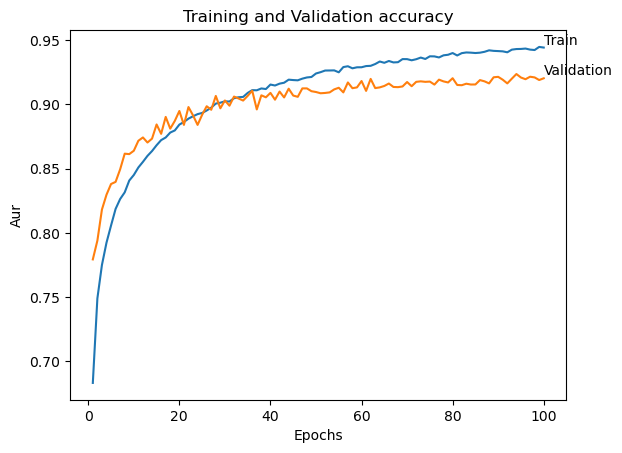

In [30]:
plt.plot(epo, train_aur)
plt.plot(epo, val_aur)
plt.xlabel('Epochs')
plt.ylabel('Aur')
plt.title('Training and Validation accuracy')
plt.text(epo[-1], train_aur[-1], 'Train', verticalalignment='bottom', horizontalalignment='left')
plt.text(epo[-1], val_aur[-1], 'Validation', verticalalignment='bottom', horizontalalignment='left')
plt.show()

In [31]:
true_pred2 = 0
count2 = 0
dnn.eval()
pred_label = []
true_label = []

with torch.no_grad():
    for z in test_loader:
        feature2 = z[0].to(device)
        feature2 = feature2.to(torch.float32)
        label2 = z[1].to(device)
        label2 = label2.view(-1, 1) 
        
        pred2 = dnn(feature2)  
        test_predicted = (pred2 > 0).float()
        true_pred2 += (test_predicted == label2).sum().item()
        count2 += feature2.size(0) 

        pred_label.append(test_predicted.cpu().detach().numpy())
        true_label.append(label2.cpu().detach().numpy())
        
y_true = np.concatenate(true_label)
y_pred = np.concatenate(pred_label)
#aur2 = true_pred2/count2
#print(f"The Accuracy of test set: {aur2}")

In [32]:
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94     13031
         1.0       0.91      0.87      0.89      7552

    accuracy                           0.92     20583
   macro avg       0.92      0.91      0.91     20583
weighted avg       0.92      0.92      0.92     20583



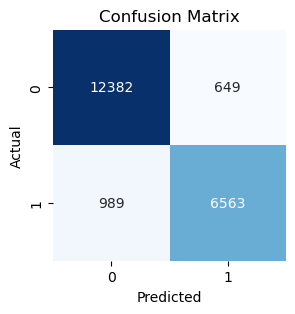

In [33]:
matrix = confusion_matrix(y_pred, y_true)

plt.figure(figsize=(3, 3))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()